# Erste deskriptive Analysen für aggregierte Daten

**Datenimport**

Importieren und Zusammenfügen der aggregierten Datensets von https://www.ckw.ch/lp/opendata.html 

Aggregierte Daten: Summierter Verbrauch pro Zeitfenster pro Gemeinde

In [82]:
%reset

In [83]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

In [84]:
dfs22 = {}
for i in range(202201, 202211):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs22["dataset{0}".format(i)] = loadData()
dfs22

{'dataset202201':         area_code                 timestamp  num_meter   value_kwh
 0            6028  2022-01-28T11:30:00.000Z        131   23.682353
 1            6028  2022-01-20T21:45:00.000Z        130   22.985000
 2            6028  2022-01-04T13:30:00.000Z        130   24.486000
 3            6028  2022-01-27T12:15:00.000Z        131   32.138353
 4            6028  2022-01-14T09:45:00.000Z        130   37.359000
 ...           ...                       ...        ...         ...
 339259       6263  2022-01-24T01:15:00.000Z        441  138.501000
 339260       6263  2022-01-17T00:45:00.000Z        441  111.416000
 339261       6263  2022-01-16T08:30:00.000Z        441  102.190000
 339262       6263  2022-01-03T18:15:00.000Z        441   88.371000
 339263       6263  2022-01-10T13:15:00.000Z        441   93.131000
 
 [339264 rows x 4 columns],
 'dataset202202':         area_code                 timestamp  num_meter  value_kwh
 0            6016  2022-02-26T12:15:00.000Z         

In [85]:
dfs21 = {}
for i in range(202101, 202113):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs21["dataset{0}".format(i)] = loadData()
dfs21

{'dataset202101':         area_code                 timestamp  num_meter   value_kwh
 0            6017  2021-01-08T09:15:00.000Z       3217  646.789607
 1            6017  2021-01-06T23:15:00.000Z       3217  710.119169
 2            6017  2021-01-04T09:45:00.000Z       3214  684.173144
 3            6017  2021-01-15T21:15:00.000Z       3532  527.497169
 4            6017  2021-01-14T07:30:00.000Z       3241  489.499607
 ...           ...                       ...        ...         ...
 319779       6284  2021-01-16T00:00:00.000Z        101   43.703000
 319780       6284  2021-01-05T22:00:00.000Z         86   29.719000
 319781       6284  2021-01-17T01:45:00.000Z        109   36.751000
 319782       6284  2021-01-18T06:15:00.000Z         89   18.799000
 319783       6284  2021-01-18T23:30:00.000Z        109   49.226000
 
 [319784 rows x 4 columns],
 'dataset202102':         area_code                 timestamp  num_meter   value_kwh
 0            6017  2021-02-20T21:45:00.000Z       3

In [86]:
df_data = pd.DataFrame()
df_data = pd.concat([
    dfs22['dataset202201'],
    dfs22['dataset202202'], 
    dfs22['dataset202203'], 
    dfs22['dataset202204'], 
    dfs22['dataset202205'], 
    dfs22['dataset202206'], 
    dfs22['dataset202207'], 
    dfs22['dataset202208'],
    dfs22['dataset202209'],
    dfs22['dataset202210'],
    dfs21['dataset202101'],
    dfs21['dataset202102'], 
    dfs21['dataset202103'], 
    dfs21['dataset202104'], 
    dfs21['dataset202105'], 
    dfs21['dataset202106'], 
    dfs21['dataset202107'], 
    dfs21['dataset202108'],
    dfs21['dataset202109'],
    dfs21['dataset202110'],
    dfs21['dataset202111'],
    dfs21['dataset202112']
], ignore_index=True,axis=0)
df_data
df_data.to_pickle("Dataset.pkl")

**Datenaufbereitung**

In [87]:
df_data = pd.read_pickle("Dataset.pkl")

In [88]:
# Datum-Variablen
df_data['date'] = df_data['timestamp'].str.slice(0, 10) 
df_data["year"] = df_data['date'].str.slice(0, 4) 
df_data["month"] = df_data['date'].str.slice(5, 7)
df_data["month-day"] = df_data['date'].str.slice(5, 7)+'-'+df_data['date'].str.slice(8,10) 
df_data["date"] = pd.to_datetime(df_data["date"])
print(df_data)

df_data = df_data[~(df_data["year"]=="2020")] # löschen der (vereinzelten) Werte aus 2020


         area_code                 timestamp  num_meter   value_kwh  \
0             6028  2022-01-28T11:30:00.000Z        131   23.682353   
1             6028  2022-01-20T21:45:00.000Z        130   22.985000   
2             6028  2022-01-04T13:30:00.000Z        130   24.486000   
3             6028  2022-01-27T12:15:00.000Z        131   32.138353   
4             6028  2022-01-14T09:45:00.000Z        130   37.359000   
...            ...                       ...        ...         ...   
7206399       6263  2021-12-14T18:30:00.000Z        442   93.188000   
7206400       6263  2021-12-11T02:45:00.000Z        440  152.357000   
7206401       6263  2021-12-10T10:30:00.000Z        440  104.941000   
7206402       6263  2021-12-10T02:00:00.000Z        440  184.617000   
7206403       6263  2021-12-27T10:30:00.000Z        441   82.090000   

              date  year month month-day  
0       2022-01-28  2022    01     01-28  
1       2022-01-20  2022    01     01-20  
2       2022-01-04

In [89]:
# Bereinigung Timestamp
df_data['timestamp'] = df_data['timestamp'].str.replace('T', '').str.replace('Z', '') 
df_data['timestamp'] = df_data['timestamp'].str[10:]
df_data['timestamp'] = df_data['timestamp'].str[:8]

In [90]:
print(df_data)
df_data.dtypes
df_data.to_pickle("Dataset.pkl")

         area_code timestamp  num_meter   value_kwh       date  year month  \
0             6028  11:30:00        131   23.682353 2022-01-28  2022    01   
1             6028  21:45:00        130   22.985000 2022-01-20  2022    01   
2             6028  13:30:00        130   24.486000 2022-01-04  2022    01   
3             6028  12:15:00        131   32.138353 2022-01-27  2022    01   
4             6028  09:45:00        130   37.359000 2022-01-14  2022    01   
...            ...       ...        ...         ...        ...   ...   ...   
7206399       6263  18:30:00        442   93.188000 2021-12-14  2021    12   
7206400       6263  02:45:00        440  152.357000 2021-12-11  2021    12   
7206401       6263  10:30:00        440  104.941000 2021-12-10  2021    12   
7206402       6263  02:00:00        440  184.617000 2021-12-10  2021    12   
7206403       6263  10:30:00        441   82.090000 2021-12-27  2021    12   

        month-day  
0           01-28  
1           01-20  
2  

**Zusammmenführen mit Gemeindegrössen und Wetterdaten**

In [91]:
# Import öffentlicher Einwohnerzahlen pro PLZ
    # anzahl: Anzahl Einwohner pro PLZ per Stichtag 1.11.2022 
    # typ: m=male, f=female, f=Firma
    
df_data = pd.read_pickle("Dataset.pkl")
df_pop = pd.read_csv('https://swisspost.opendatasoft.com/api/v2/catalog/datasets/bevoelkerung_proplz/exports/csv', delimiter= ';')
df_pop.info()
df_pop.rename(columns={'plz':'area_code'}, inplace=True)
df_pop 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stichdatum  9552 non-null   object 
 1   plz         9549 non-null   float64
 2   anzahl      9552 non-null   int64  
 3   typ         9552 non-null   object 
 4   ortbez18    9546 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 373.2+ KB


,stichdatum,area_code,anzahl,typ,ortbez18
0,2022-11-01,2915.0,404,m,Bure
1,2022-11-01,2915.0,86,f,Bure
2,2022-11-01,2916.0,227,w,Fahy
3,2022-11-01,2916.0,212,m,Fahy
4,2022-11-01,2923.0,69,f,Courtemaîche
...,...,...,...,...,...
9547,2022-11-01,9650.0,261,f,Nesslau
9548,2022-11-01,9651.0,51,f,Ennetbühl
9549,2022-11-01,9655.0,251,m,Stein SG
9550,2022-11-01,9656.0,433,w,Alt St. Johann


In [92]:
# Zusammenführen mit Verbrauchsdaten
df_data = pd.merge(df_data, df_pop, how="left", on=["area_code"])

In [93]:
# Reshape von "Typ"
df_data=df_data.pivot(index=['area_code', 'timestamp', 'num_meter', 'value_kwh', 'stichdatum', 'ortbez18', 'date', 'year', 'month-day', 'month'], columns='typ', values=['anzahl']).reset_index()
df_data

area_code timestamp num_meter value_kwh  stichdatum      ortbez18  \
typ                                                                         
0            4806  00:00:00        24     4.874  2022-11-01         Wikon   
1            4806  00:00:00        24     4.876  2022-11-01         Wikon   
2            4806  00:00:00        24     4.897  2022-11-01         Wikon   
3            4806  00:00:00        24     5.088  2022-11-01         Wikon   
4            4806  00:00:00        24     5.125  2022-11-01         Wikon   
...           ...       ...       ...       ...         ...           ...   
7205820      6344  23:45:00       925   115.326  2022-11-01  Meierskappel   
7205821      6344  23:45:00       926    90.028  2022-11-01  Meierskappel   
7205822      6344  23:45:00       926   113.082  2022-11-01  Meierskappel   
7205823      6344  23:45:00       926   117.300  2022-11-01  Meierskappel   
7205824      6344  23:45:00       926   205.924  2022-11-01  Meierskappel   

              date  year month-day month anzahl            
typ                                           f    m    w  
0       2021-01-11  2021     01-11    01    124  804  779  
1       2021-01-22  2021     01-22    01    124  804  779  
2       2021-01-26  2021     01-26    01    124  804  779  
3       2021-01-13  2021     01-13    01    124  804  779  
4       2021-01-06  2021     01-06    01    124  804  779  
...            ...   ...       ...   ...    ...  ...  ...  
7205820 2022-06-11  2022     06-11    06    220  947  907  
7205821 2022-08-01  2022     08-01    08    220  947  907  
7205822 2022-07-13  2022     07-13    07    220  947  907  
7205823 2022-05-19  2022     05-19    05    220  947  907  
7205824 2022-04-10  2022     04-10    04    220  947  907  

[7205825 rows x 13 columns]

In [94]:
df_data['num_address']=df_data['anzahl','f'] + df_data['anzahl','m'] + df_data['anzahl','w'] # Anzahl totale Einwohner pro Gemeinde
df_data.columns = df_data.columns.droplevel('typ') # Löschen Index-Hierarchie
del df_data['stichdatum'] # Löschen col Stichdatum

In [95]:
df_data.columns.values[9:12] =['num_f', 'num_m', 'num_w' ] # Umbenennen cols
df_data.to_pickle("Dataset01.pkl")
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month-day,month,num_f,num_m,num_w,num_address
0,4806,00:00:00,24,4.874,Wikon,2021-01-11,2021,01-11,01,124,804,779,1707
1,4806,00:00:00,24,4.876,Wikon,2021-01-22,2021,01-22,01,124,804,779,1707
2,4806,00:00:00,24,4.897,Wikon,2021-01-26,2021,01-26,01,124,804,779,1707
3,4806,00:00:00,24,5.088,Wikon,2021-01-13,2021,01-13,01,124,804,779,1707
4,4806,00:00:00,24,5.125,Wikon,2021-01-06,2021,01-06,01,124,804,779,1707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205820,6344,23:45:00,925,115.326,Meierskappel,2022-06-11,2022,06-11,06,220,947,907,2074
7205821,6344,23:45:00,926,90.028,Meierskappel,2022-08-01,2022,08-01,08,220,947,907,2074
7205822,6344,23:45:00,926,113.082,Meierskappel,2022-07-13,2022,07-13,07,220,947,907,2074
7205823,6344,23:45:00,926,117.300,Meierskappel,2022-05-19,2022,05-19,05,220,947,907,2074


In [96]:
df_data = pd.read_pickle("Dataset01.pkl")

In [97]:
# Import öffentlicher Wetterdaten
    # tre200d0 = °C Lufttemperatur 2 m über Boden; Tagesmittel

df_temp22= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_current.csv', delimiter= ';') # 2022
df_temp22=df_temp22[['tre200d0', 'station/location', 'date']]
df_temp22["date"] = pd.to_datetime(df_temp22["date"], format='%Y%m%d')
df_temp22.rename(columns={'tre200d0':'daytemp'}, inplace=True)
df_temp22.info()
df_temp22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   daytemp           313 non-null    float64       
 1   station/location  313 non-null    object        
 2   date              313 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.5+ KB


,daytemp,station/location,date
0,3.6,LUZ,2022-01-01
1,4.9,LUZ,2022-01-02
2,9.6,LUZ,2022-01-03
3,9.0,LUZ,2022-01-04
4,1.3,LUZ,2022-01-05
...,...,...,...
308,6.6,LUZ,2022-11-05
309,5.6,LUZ,2022-11-06
310,8.0,LUZ,2022-11-07
311,7.8,LUZ,2022-11-08


In [98]:
df_temp21= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_previous.csv', delimiter= ';') # 2021
df_temp21=df_temp21[['tre200d0', 'station/location', 'date']]
df_temp21["date"] = pd.to_datetime(df_temp21["date"], format='%Y%m%d')
df_temp21.rename(columns={'tre200d0':'daytemp'}, inplace=True)
df_temp21.info()
df_temp21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51671 entries, 0 to 51670
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   daytemp           51671 non-null  float64       
 1   station/location  51671 non-null  object        
 2   date              51671 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


,daytemp,station/location,date
0,17.1,LUZ,1880-07-13
1,18.3,LUZ,1880-07-14
2,20.9,LUZ,1880-07-15
3,22.9,LUZ,1880-07-16
4,23.8,LUZ,1880-07-17
...,...,...,...
51666,4.1,LUZ,2021-12-27
51667,6.7,LUZ,2021-12-28
51668,7.2,LUZ,2021-12-29
51669,9.5,LUZ,2021-12-30


In [99]:
# Zusammenführen mit Verbrauchsdaten
df_temp = pd.concat([df_temp22, df_temp21], ignore_index=True,axis=0)
df_temp

,daytemp,station/location,date
0,3.6,LUZ,2022-01-01
1,4.9,LUZ,2022-01-02
2,9.6,LUZ,2022-01-03
3,9.0,LUZ,2022-01-04
4,1.3,LUZ,2022-01-05
...,...,...,...
51979,4.1,LUZ,2021-12-27
51980,6.7,LUZ,2021-12-28
51981,7.2,LUZ,2021-12-29
51982,9.5,LUZ,2021-12-30


In [100]:
df_data = pd.merge(df_data, df_temp, how="left", on=["date"]) # Zusammenfügen mit Verbrauchsdaten
df_data
df_data.to_pickle("Dataset02.pkl")

In [101]:
#Export
os.makedirs('C:/Users/ckw-stea/Desktop/Python/', exist_ok=True)  
df_data.to_csv('C:/Users/ckw-stea/Desktop/Python/dataset.csv')  

**Zusätzliche Variablen**

In [102]:
df_data = pd.read_pickle("Dataset02.pkl")
df_data.dtypes

area_code                    int64
timestamp                   object
num_meter                    int64
value_kwh                  float64
ortbez18                    object
date                datetime64[ns]
year                        object
month-day                   object
month                       object
num_f                        int64
num_m                        int64
num_w                        int64
num_address                  int64
daytemp                    float64
station/location            object
dtype: object

In [103]:
#Durchschnittlicher Verbrauch pro Smart Meter pro 15-minZeitfenster

df_data['kwh_perdatetime']=df_data.groupby(['date', 'timestamp'])['value_kwh'].transform('sum') #Total kwh pro date-timeframe über alle Gemeinden
df_data['sm_perdatetime']=df_data.groupby(['date', 'timestamp'])['num_meter'].transform('sum') # Number of Smart Meters per date-timeframe 
df_data['kwh_persmdt']=df_data['kwh_perdatetime']/df_data['sm_perdatetime'] # kwh pro date-timeframe pro Smart Meter

In [104]:
df_data.sort_values(['date', 'timestamp'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month-day,month,num_f,num_m,num_w,num_address,daytemp,station/location,kwh_perdatetime,sm_perdatetime,kwh_persmdt
13,4806,00:00:00,24,6.115000,Wikon,2021-01-01,2021,01-01,01,124,804,779,1707,1.7,LUZ,12380.544823,39216,0.315701
119854,5735,00:00:00,14,2.600739,Pfeffikon LU,2021-01-01,2021,01-01,01,74,453,436,963,1.7,LUZ,12380.544823,39216,0.315701
183353,6005,00:00:00,114,21.258000,St. Niklausen LU/Luzern,2021-01-01,2021,01-01,01,3192,12599,13709,29500,1.7,LUZ,12380.544823,39216,0.315701
246818,6010,00:00:00,1801,211.804188,Kriens/Pilatus Kulm,2021-01-01,2021,01-01,01,2535,14560,14485,31580,1.7,LUZ,12380.544823,39216,0.315701
310343,6014,00:00:00,27,8.638000,Luzern,2021-01-01,2021,01-01,01,1263,5774,5613,12650,1.7,LUZ,12380.544823,39216,0.315701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754441,6182,07:30:00,26,2.310000,Escholzmatt,2022-10-24,2022,10-24,10,244,1512,1512,3268,13.6,LUZ,8.410000,131,0.064198
6677116,6284,07:30:00,16,1.170000,Gelfingen/Sulz LU,2022-10-24,2022,10-24,10,96,708,737,1541,13.6,LUZ,8.410000,131,0.064198
1204249,6030,07:45:00,15,0.610000,Ebikon,2022-10-24,2022,10-24,10,1442,8323,8213,17978,13.6,LUZ,1.240000,26,0.047692
1267737,6032,07:45:00,11,0.630000,Emmen,2022-10-24,2022,10-24,10,789,4425,4350,9564,13.6,LUZ,1.240000,26,0.047692


In [105]:
#Durchschnittlicher Verbrauch pro Smart Meter pro Gemeinde
df_data['kwh_permeterarea'] = df_data['value_kwh']/df_data['num_meter']

In [106]:
df_data.to_pickle("Dataset03.pkl")

**Grafiken**

In [107]:
df_data = pd.read_pickle("Dataset03.pkl")
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month-day,month,num_f,num_m,num_w,num_address,daytemp,station/location,kwh_perdatetime,sm_perdatetime,kwh_persmdt,kwh_permeterarea
0,4806,00:00:00,24,4.874,Wikon,2021-01-11,2021,01-11,01,124,804,779,1707,-2.7,LUZ,10312.370118,40442,0.254992,0.203083
1,4806,00:00:00,24,4.876,Wikon,2021-01-22,2021,01-22,01,124,804,779,1707,5.8,LUZ,8549.513166,42453,0.201388,0.203167
2,4806,00:00:00,24,4.897,Wikon,2021-01-26,2021,01-26,01,124,804,779,1707,0.3,LUZ,10145.871653,45124,0.224844,0.204042
3,4806,00:00:00,24,5.088,Wikon,2021-01-13,2021,01-13,01,124,804,779,1707,3.3,LUZ,8654.951530,41157,0.210291,0.212000
4,4806,00:00:00,24,5.125,Wikon,2021-01-06,2021,01-06,01,124,804,779,1707,-0.3,LUZ,9711.398670,39726,0.244460,0.213542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205820,6344,23:45:00,925,115.326,Meierskappel,2022-06-11,2022,06-11,06,220,947,907,2074,18.9,LUZ,10629.972820,104936,0.101300,0.124677
7205821,6344,23:45:00,926,90.028,Meierskappel,2022-08-01,2022,08-01,08,220,947,907,2074,23.2,LUZ,9049.487259,105706,0.085610,0.097222
7205822,6344,23:45:00,926,113.082,Meierskappel,2022-07-13,2022,07-13,07,220,947,907,2074,22.2,LUZ,10588.150724,105552,0.100312,0.122119
7205823,6344,23:45:00,926,117.300,Meierskappel,2022-05-19,2022,05-19,05,220,947,907,2074,19.6,LUZ,11153.624296,105103,0.106121,0.126674


Text(0, 0.5, 'Ø Stromverbrauch pro Smart Meter pro Tag')

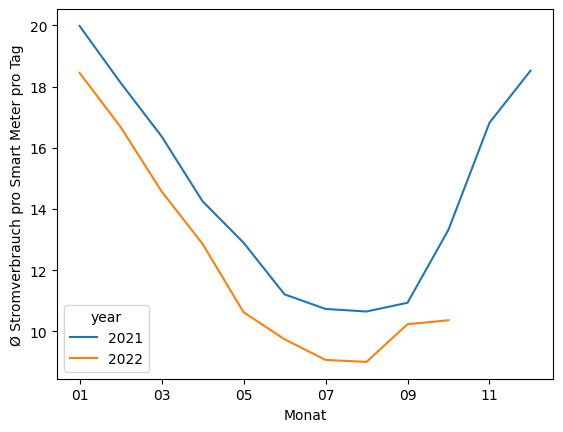

In [108]:
#Durchschnittlicher Verbrauch pro Smart Meter pro Tag 

df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Gemeinde-Ebene löschen um Verbrauchsdaten auf Zeitachse zu aggregieren
df_datashort.sort_values(['date', 'timestamp'])

df_day=df_datashort.groupby(['year','month', 'date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag
df_day

df_day.pivot_table(values="kwh_persmdt", index="month", columns="year").plot()

plt.xlabel("Monat")
plt.ylabel("Ø Stromverbrauch pro Smart Meter pro Tag")


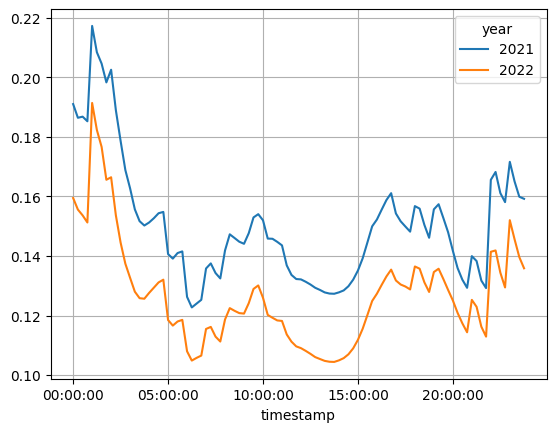

In [109]:
# Durchschnittlicher Verbrauch pro Smart Meter über Tageszeit
df_data.pivot_table(values="kwh_persmdt", index="timestamp", columns="year").plot()
plt.grid()
plt.show()

In [110]:
df_data = pd.read_pickle("Dataset03.pkl")

Text(0, 0.5, 'Ø Stromverbrauch pro Smart Meter pro Tag')

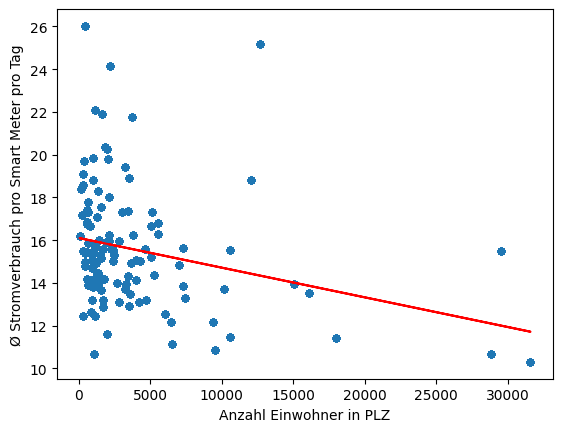

In [111]:
# Durchschnittlicher Verbrauch pro Smart Meter & Tag nach Gemeindegrösse
df_data['kwh_perDay'] = df_data.groupby(['area_code', 'date'])['kwh_permeterarea'].transform(np.sum) # Verbrauch pro Meter pro Tag pro Gemeinde
df_data['mean_perArea_perDay'] = df_data.groupby(['area_code'])['kwh_perDay'].transform(np.mean) # durchschnittlicher Verbrauch pro Meter pro Tag pro Gemeinde
df_data.plot.scatter(x = "num_address", y = 'mean_perArea_perDay') # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag

m, b = np.polyfit(df_data["num_address"], df_data["mean_perArea_perDay"], 1) # m = slope, b=intercept
plt.plot(df_data["num_address"], m*df_data["num_address"] + b, color="r")

plt.xlabel("Anzahl Einwohner in PLZ")
plt.ylabel("Ø Stromverbrauch pro Smart Meter pro Tag")

In [112]:
#Top 10 / Bottom 10 Gemeinden

df_area=df_data.groupby(['area_code', 'ortbez18'])[['kwh_perDay']].mean()
df_area.nlargest(10, 'kwh_perDay') #print top 10

,,kwh_perDay
area_code,ortbez18,
6245,Ebersecken,26.026432
6014,Luzern,25.198936
6133,Hergiswil LU,24.153679
6231,Schlierbach,22.108862
6047,Kastanienbaum,21.896374
6026,Rain,21.746122
6243,Egolzwil,20.365098
6203,Sempach Station,20.274341
6213,Knutwil,19.860434


In [113]:
df_area.nsmallest(10, 'kwh_perDay') #print bottom 10

,,kwh_perDay
area_code,ortbez18,
6010,Kriens/Pilatus Kulm,10.303179
4915,St. Urban,10.667895
6020,Emmenbrücke,10.685013
6032,Emmen,10.874770
6037,Root,11.120677
6030,Ebikon,11.445554
6015,Luzern,11.479666
6036,Dierikon,11.597726
6130,Willisau,12.181310


In [114]:
#Temperatur und Verbrauch
df_day=df_datashort.groupby(['year','month', 'date', 'daytemp'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag
df_day

kwh_persmdt
year month date       daytemp             
2021 01    2021-01-01  1.7       18.508098
           2021-01-02  1.5       18.812322
           2021-01-03  0.5       19.017458
           2021-01-04  0.1       21.118239
           2021-01-05 -0.2       20.878236
...                                    ...
2022 10    2022-10-20  14.4      10.987537
           2022-10-21  14.5      11.149362
           2022-10-22  14.3      10.946056
           2022-10-23  13.8      10.641075
           2022-10-24  13.6       3.138861

[662 rows x 1 columns]


col1 = 'steelblue' #define colors to use
col2 = 'red'

fig,ax = plt.subplots() #define subplots

ax.plot(df1.year, df1.sales, color=col1) #add first line to plot

#add x-axis label
ax.set_xlabel('Year', fontsize=14)

#add y-axis label
ax.set_ylabel('Sales', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(df2.year, df2.leads, color=col2)

#add second y-axis label
ax2.set_ylabel('Leads', color=col2, fontsize=16)

Ergänzung von Feiertagen und Ferien